# Временные ряды и построение моделей на примере данных пассажиропотока

In [ ]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
# Сначала создаем ту же модель (с той же архитектурой)
model = ssdlite320_mobilenet_v3_large(pretrained=False).to(device)


## Загрузка библиотек

In [ ]:
# установка дополнительной библиотеки
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.4 MB/s eta 0:00:00


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd # работа с таблицами
import numpy as np # математические вычисления
from scipy import stats # статистические методы
import matplotlib
import matplotlib.pyplot as plt # визуализация данных

from dateutil.parser import parse # парсер даты

from statsmodels.tsa.seasonal import seasonal_decompose # оценка сезонности
from statsmodels.tsa.ar_model import AutoReg #AR модель
from scipy.stats import normaltest # критерий Д'Агостино K^2, оценка данных на распределение Гаусса
from statsmodels.tsa.statespace.tools import diff  # разность рядов просто и/или сезонно вдоль нулевой оси
from statsmodels.tsa.arima_model import ARMAResults,ARIMAResults # Получить результаты после fit ARMA, ARIMA
from statsmodels.tsa.arima.model import ARIMA # Построить модель ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX # Построить модель SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # plot_acf график автокорреляции, plot_pacf частичной автокорреляции
from statsmodels.graphics.tsaplots import month_plot,quarter_plot # график сезонности данных по месяцам, кварталам
from pandas.plotting import lag_plot # график лага

from statsmodels.tsa.stattools import adfuller # тест Дики-Фуллера

from sklearn.metrics import mean_squared_error # метрика качества MSE
from statsmodels.tools.eval_measures import rmse  # метрика качества Квадратный корень из MSE

from pmdarima import auto_arima # автоматический подбор параметров

In [2]:
plt.rcParams["figure.figsize"] = (10,5) # размер графиков

plt.style.use('fivethirtyeight') # стиль графиков

In [13]:
adfuller?


Signature:
adfuller(
    x,
    maxlag: 'int | None' = None,
    regression='c',
    autolag='AIC',
    store=False,
    regresults=False,
)
Docstring:
Augmented Dickey-Fuller unit root test.

The Augmented Dickey-Fuller test can be used to test for a unit root in a
univariate process in the presence of serial correlation.

Parameters
----------
x : array_like, 1d
    The data series to test.
maxlag : {None, int}
    Maximum lag which is included in test, default value of
    12*(nobs/100)^{1/4} is used when ``None``.
regression : {"c","ct","ctt","n"}
    Constant and trend order to include in regression.

    * "c" : constant only (default).
    * "ct" : constant and trend.
    * "ctt" : constant, and linear and quadratic trend.
    * "n" : no constant, no trend.

autolag : {"AIC", "BIC", "t-stat", None}
    Method to use when automatically determining the lag length among the
    values 0, 1, ..., maxlag.

    * If "AIC" (default) or "BIC", then the number of lags is chosen
      to 

In [18]:
def adf_test(series,title=''):
  '''
  тест Дики-Фуллера
  0 гипотеза: ряд данных не стационарен
  альтернативная гипотеза: ряд данных стационарен
  Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
  @param series - значения ряда
  @param title - заголовок ряда
  '''

  result = adfuller(series.dropna(),autolag='AIC') # тест предполагает линейный тренд

  labels = ['ADF тест','p-value','# lags used','# наблюдения']
  out = pd.Series(result[0:4],index=labels)

  for key,val in result[4].items():
      out[f'критическое значение ({key})']=val

  print(out.to_string())

  if result[1] <= 0.05:
      print("Сильные доказательства против нулевой гипотезы")
      print("Отменяем 0 гипотезу")
      print("Данные стационарны")
  else:
      print("Слабые доказательства против нулевой гипотезы")
      print("Не отменяем 0 гипотезу")
      print("Данные не стационарны")

## Данные

In [4]:
# загрузка данных
# index_col="time" (колонка индекс)
# parse_dates= True
df= pd.read_csv(
    "https://raw.githubusercontent.com/lucasjinreal/LSTM_learn/master/international-airline-passengers.csv",
    index_col="time", parse_dates= True
    ) #datetime

df.head()

,passengers
time,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
df.dtypes

,0
passengers,int64


In [ ]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [ ]:
len(df)

144

In [ ]:
# удаление пропущенных значений
df.dropna(inplace=True)

In [ ]:
# создаем индекс (уникальность) по полю дата
df.index= pd.to_datetime(df.index)

In [ ]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='time', length=144, freq=None)

## Анализ временного ряда

In [ ]:
# дескриптивная аналитики
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


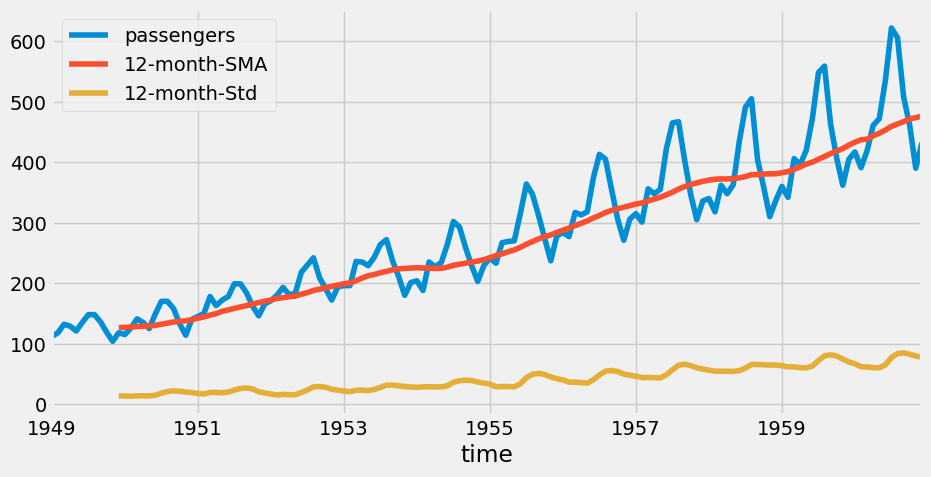

In [ ]:
# дескриптивная аналитики, расчеты скользящего окна
df['12-month-SMA'] = df['passengers'].rolling(window=12).mean()
df['12-month-Std'] = df['passengers'].rolling(window=12).std()

df[['passengers','12-month-SMA','12-month-Std']].plot();

In [ ]:
# наглядно показываем какие есть столбцы
df.columns

Index(['passengers', '12-month-SMA', '12-month-Std'], dtype='object')

In [12]:
seasonal_decompose?

Signature:
seasonal_decompose(
    x,
    model='additive',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
)
Docstring:
Seasonal decomposition using moving averages.

Parameters
----------
x : array_like
    Time series. If 2d, individual series are in columns. x must contain 2
    complete cycles.
model : {"additive", "multiplicative"}, optional
    Type of seasonal component. Abbreviations are accepted.
filt : array_like, optional
    The filter coefficients for filtering out the seasonal component.
    The concrete moving average method used in filtering is determined by
    two_sided.
period : int, optional
    Period of the series (e.g., 1 for annual, 4 for quarterly, etc). Must
    be used if x is not a pandas object or if the index of x does not have
    a frequency. Overrides default periodicity of x if x is a pandas
    object with a timeseries index.
two_sided : bool, optional
    The moving average method used in filtering.
    If True (default)

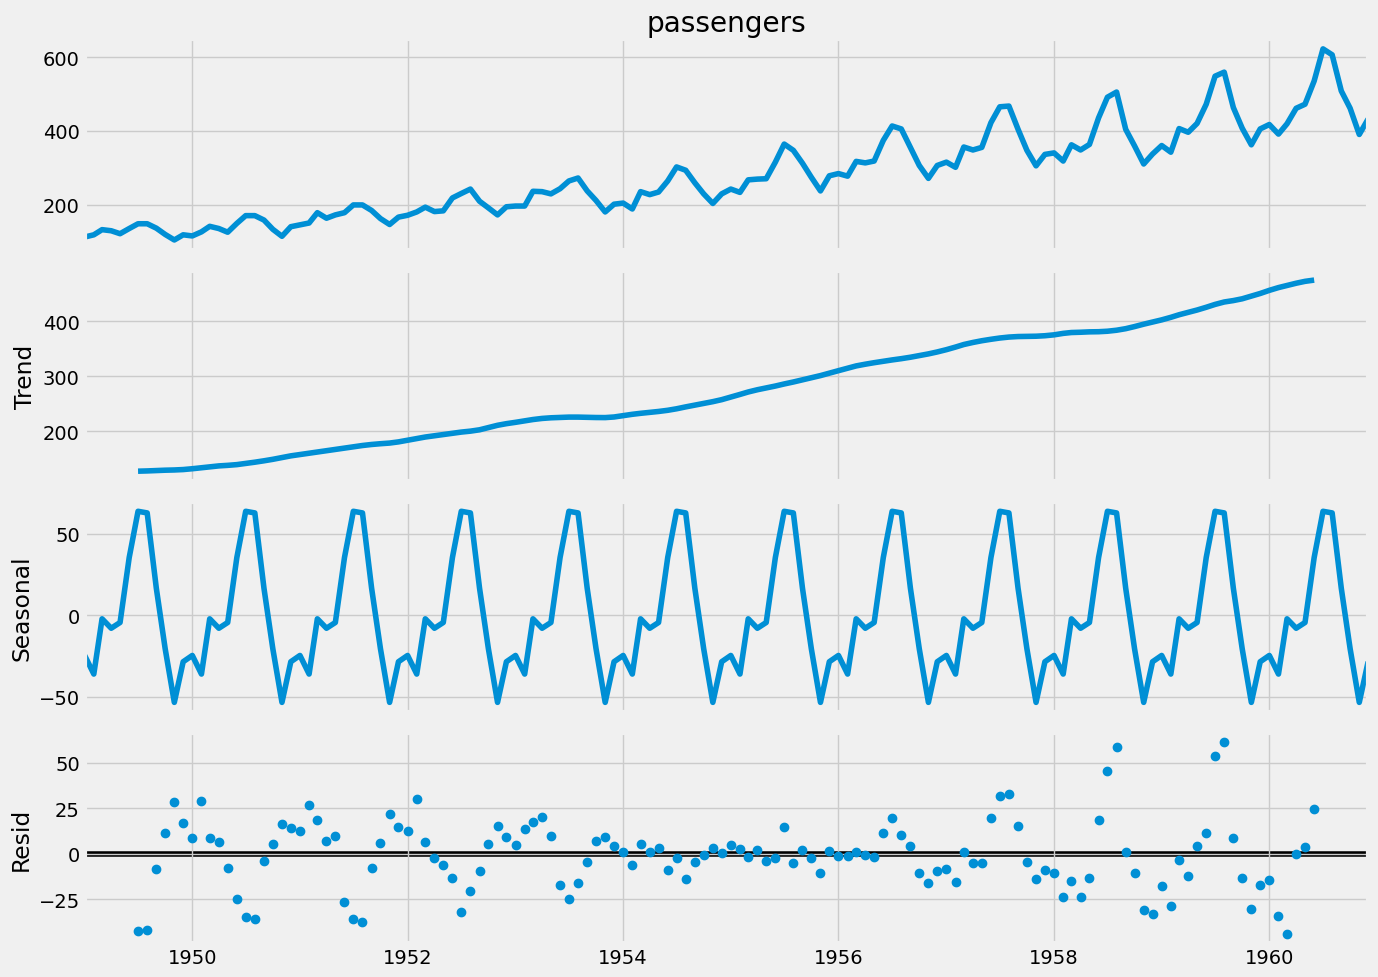

In [ ]:
# сезонная декомпозиция
ssn= seasonal_decompose(df["passengers"], model="add")
fig = ssn.plot()
fig.set_size_inches((14, 10))
fig.tight_layout()
plt.show()

In [ ]:
frequency = df.index.freq
if frequency == 'D':
    period = 7  # для ежедневных данных
elif frequency == 'W':
    period = 52  # для еженедельных данных
elif frequency == 'M':
    period = 12  # для ежемесячных данных
elif frequency == 'Q':
    period = 4  # для квартальных данных
else:
    period = None  # для других типов данных

print(f"Частота данных: {frequency}, Период: {period}")

Частота данных: None, Период: None


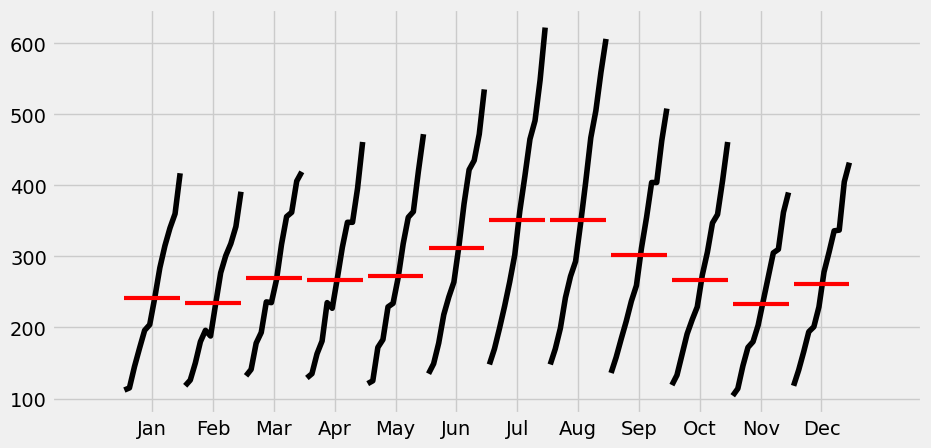

In [ ]:
# построим новый вид графика
month_plot(df['passengers']);

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

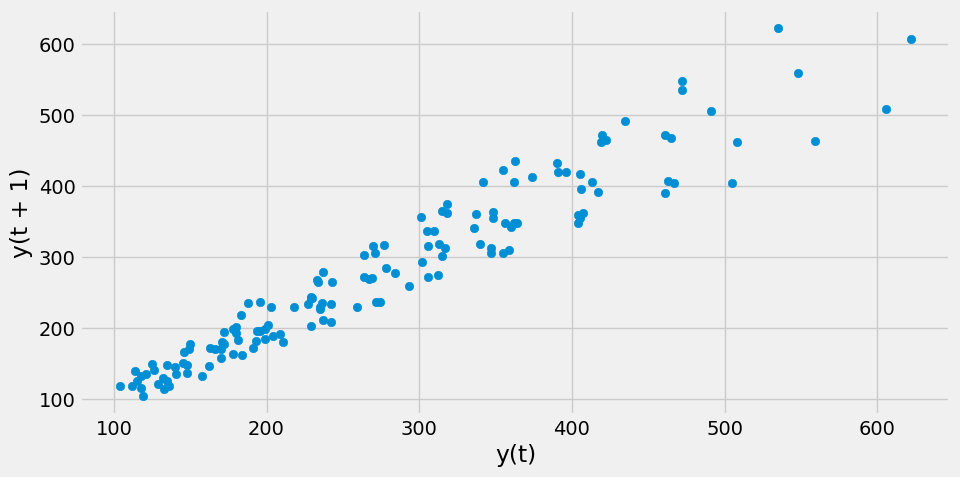

In [ ]:
# автокорреляция значения t+1 (следующий лаг времени) от текущего (t)
# здесь есть строгая корреляция
lag_plot(df['passengers'])

In [ ]:
len(df)

144

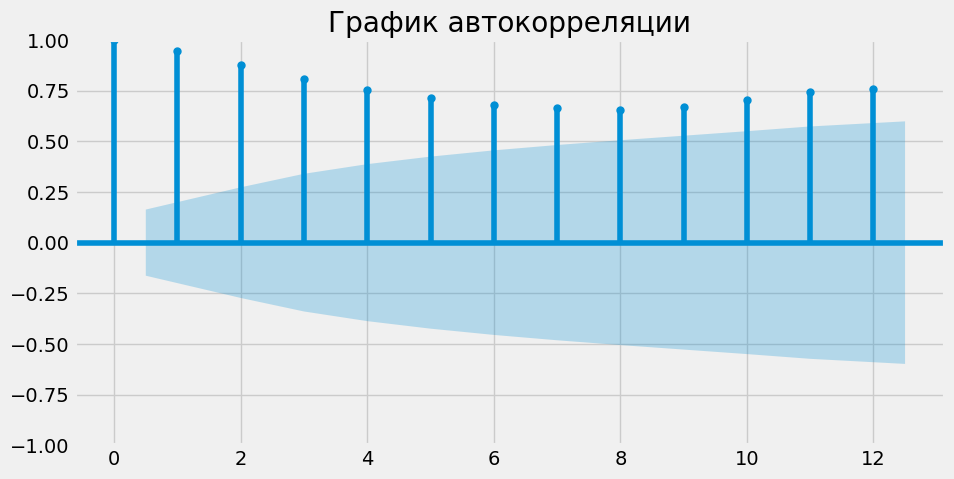

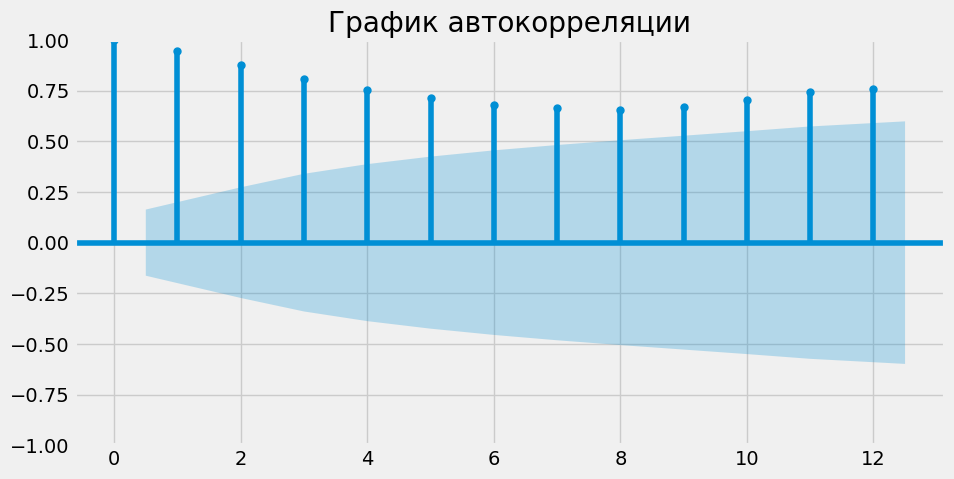

In [9]:
# ACF
title = 'График автокорреляции'
lags = 12 # оптимальное значение (т.к. большой времнной период)
plot_acf(df["passengers"],title=title,lags=lags)

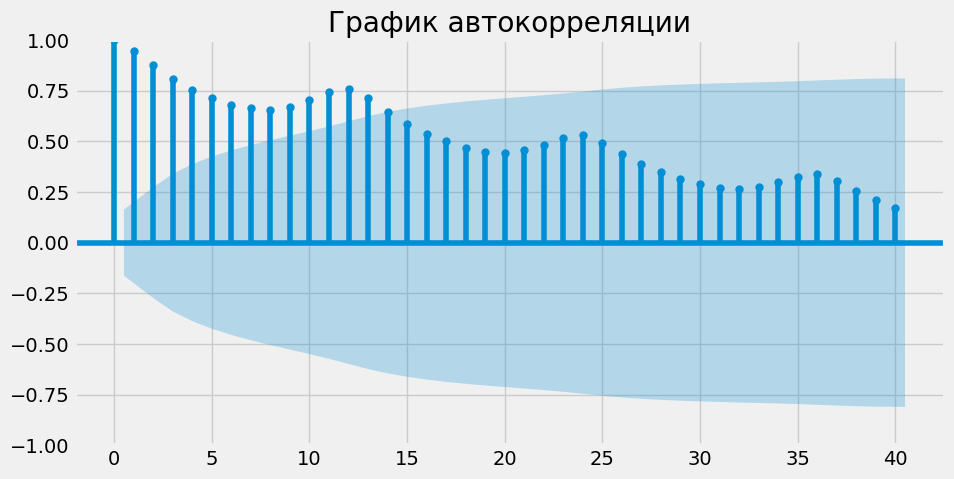

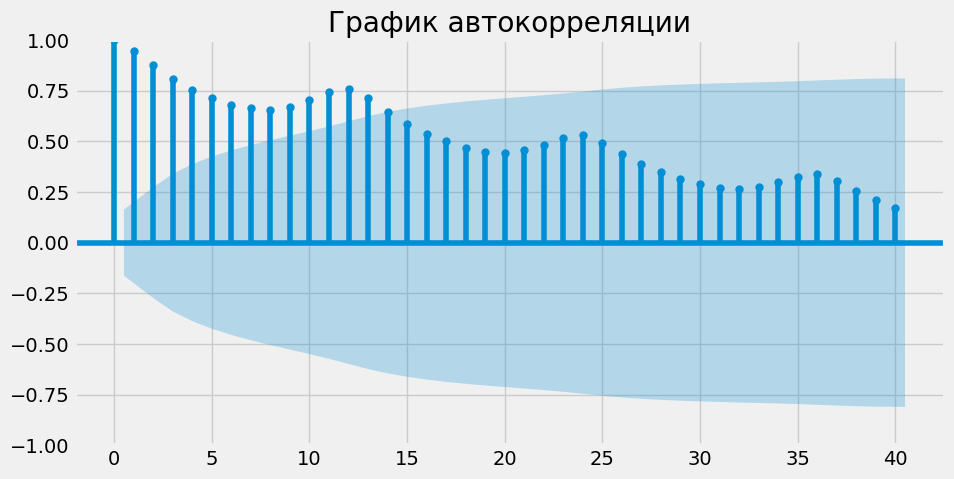

In [8]:
# ACF
title = 'График автокорреляции'
lags = 40 # оптимальное значение (т.к. большой времнной период)
plot_acf(df["passengers"],title=title,lags=lags)

In [11]:
plot_pacf?

Signature:
plot_pacf(
    x,
    ax=None,
    lags=None,
    alpha=0.05,
    method='ywm',
    use_vlines=True,
    title='Partial Autocorrelation',
    zero=True,
    vlines_kwargs=None,
    **kwargs,
)
Docstring:
Plot the partial autocorrelation function

Parameters
----------
x : array_like
    Array of time-series values
ax : AxesSubplot, optional
    If given, this subplot is used to plot in instead of a new figure being
    created.
lags : {int, array_like}, optional
    An int or array of lag values, used on horizontal axis. Uses
    np.arange(lags) when lags is an int.  If not provided,
    ``lags=np.arange(len(corr))`` is used.
alpha : float, optional
    If a number is given, the confidence intervals for the given level are
    returned. For instance if alpha=.05, 95 % confidence intervals are
    returned where the standard deviation is computed according to
    1/sqrt(len(x))
method : str
    Specifies which method for the calculations to use:

    - "ywm" or "ywmle" : Yule

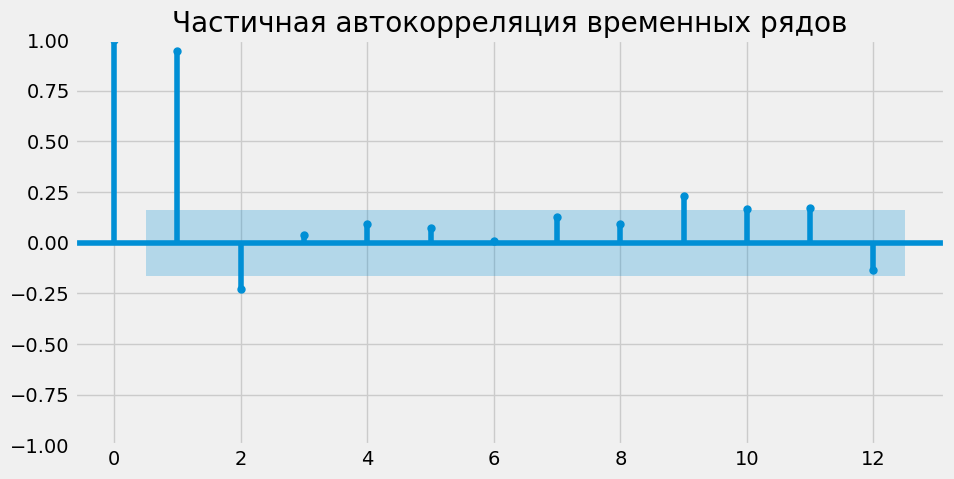

In [10]:
# PACF - функция частичной автокорреляции дает частичную корреляцию стационарного временного ряда с его собственными запаздывающими значениями
title = 'Частичная автокорреляция временных рядов'
lags = 12
plot_pacf(df["passengers"],title=title,lags=lags);

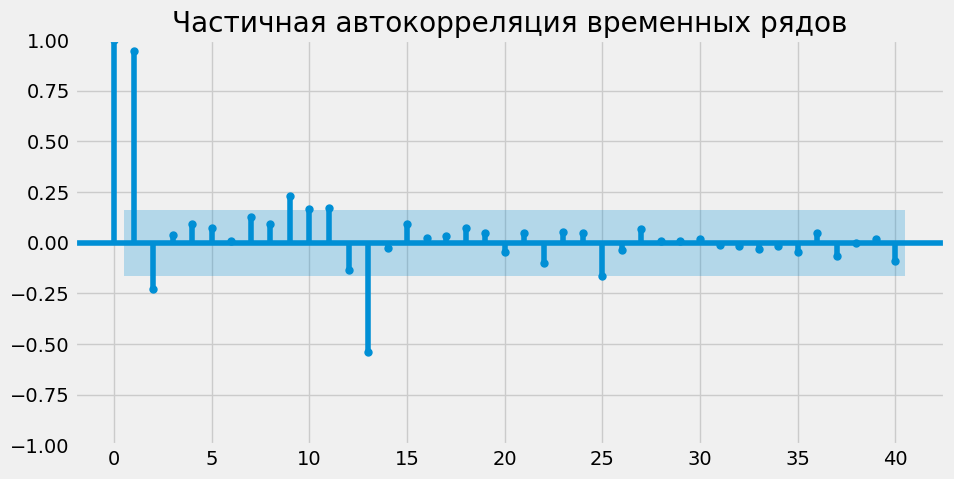

In [ ]:
# PACF - функция частичной автокорреляции дает частичную корреляцию стационарного временного ряда с его собственными запаздывающими значениями
title = 'Частичная автокорреляция временных рядов'
lags = 40
plot_pacf(df["passengers"],title=title,lags=lags);

### Стационарность

In [19]:
# тест на стационарность, p-value < 0.05
adf_test(df["passengers"])

ADF тест                        0.815369
p-value                         0.991880
# lags used                    13.000000
# наблюдения                  130.000000
критическое значение (1%)      -3.481682
критическое значение (5%)      -2.884042
критическое значение (10%)     -2.578770
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


In [20]:
adfuller(df["passengers"],autolag='AIC', store=True, regresults=True) # тест предполагает линейный тренд

(0.8153688792060482,
 0.991880243437641,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 <statsmodels.stats.diagnostic.ResultsStore at 0x180eb6500b0>)

<Axes: xlabel='time'>

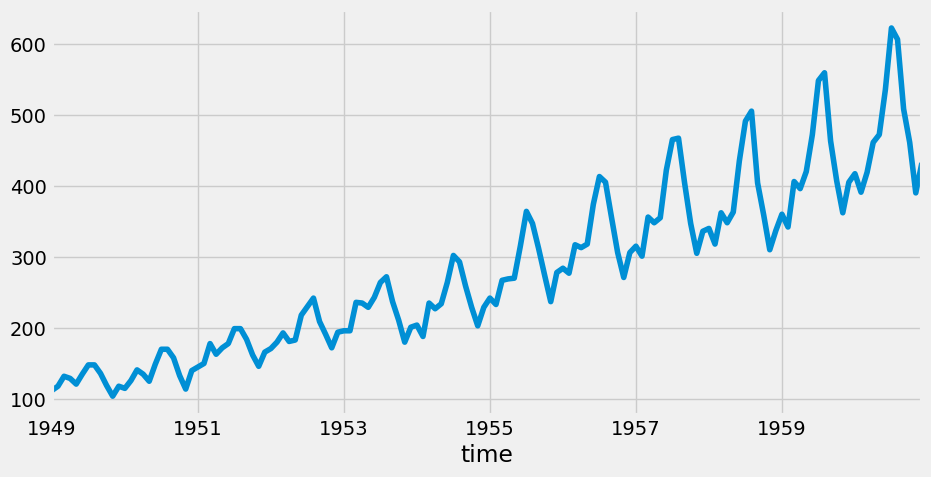

In [ ]:
df["passengers"].plot()

In [22]:
diff?

Signature: diff(series, k_diff=1, k_seasonal_diff=None, seasonal_periods=1)
Docstring:
Difference a series simply and/or seasonally along the zero-th axis.

Given a series (denoted :math:`y_t`), performs the differencing operation

.. math::

    \Delta^d \Delta_s^D y_t

where :math:`d =` `diff`, :math:`s =` `seasonal_periods`,
:math:`D =` `seasonal\_diff`, and :math:`\Delta` is the difference
operator.

Parameters
----------
series : array_like
    The series to be differenced.
k_diff : int, optional
    The number of simple differences to perform. Default is 1.
k_seasonal_diff : int or None, optional
    The number of seasonal differences to perform. Default is no seasonal
    differencing.
seasonal_periods : int, optional
    The seasonal lag. Default is 1. Unused if there is no seasonal
    differencing.

Returns
-------
differenced : ndarray
    The differenced array.
File:      c:\program files\python312\lib\site-packages\statsmodels\tsa\statespace\tools.py
Type:      function

<Axes: xlabel='time'>

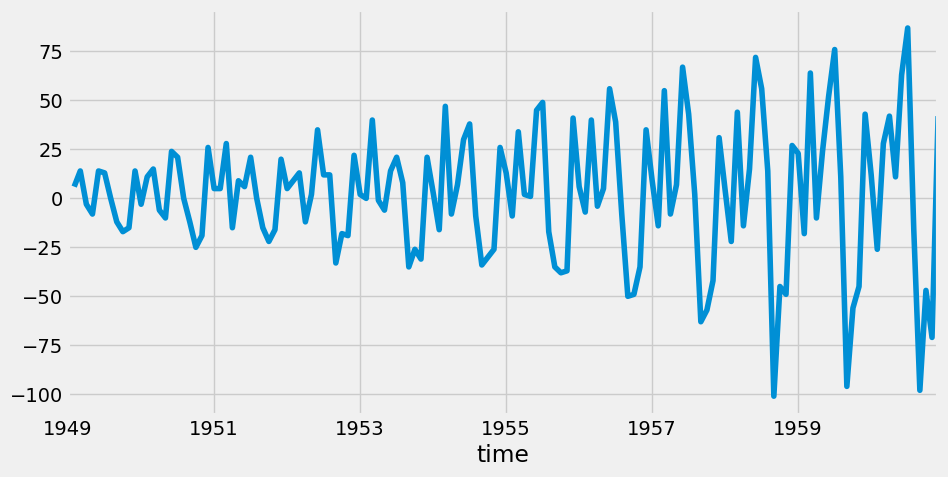

In [ ]:
# сконвертируем нестационарный ряд в стационарный
# Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
df["difference_1"]= diff(df["passengers"], k_diff=1)
df["difference_1"].plot()

In [ ]:
adf_test(df["difference_1"])

ADF тест                       -2.829267
p-value                         0.054213
# lags used                    12.000000
# наблюдения                  130.000000
критическое значение (1%)      -3.481682
критическое значение (5%)      -2.884042
критическое значение (10%)     -2.578770
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


<Axes: xlabel='time'>

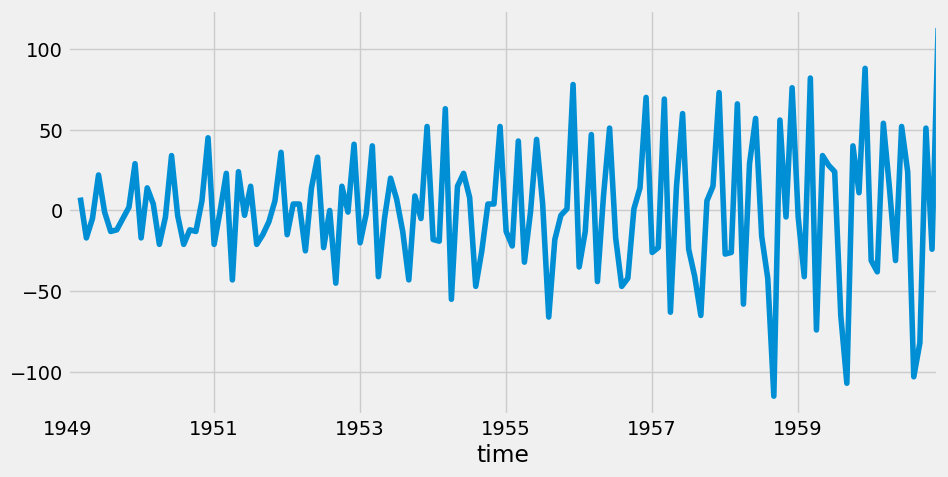

In [ ]:
df["difference_2"]= diff(df["passengers"], k_diff=2)
df["difference_2"].plot()

In [ ]:
adf_test(df["difference_2"])

ADF тест                     -1.638423e+01
p-value                       2.732892e-29
# lags used                   1.100000e+01
# наблюдения                  1.300000e+02
критическое значение (1%)    -3.481682e+00
критическое значение (5%)    -2.884042e+00
критическое значение (10%)   -2.578770e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


<Axes: xlabel='time'>

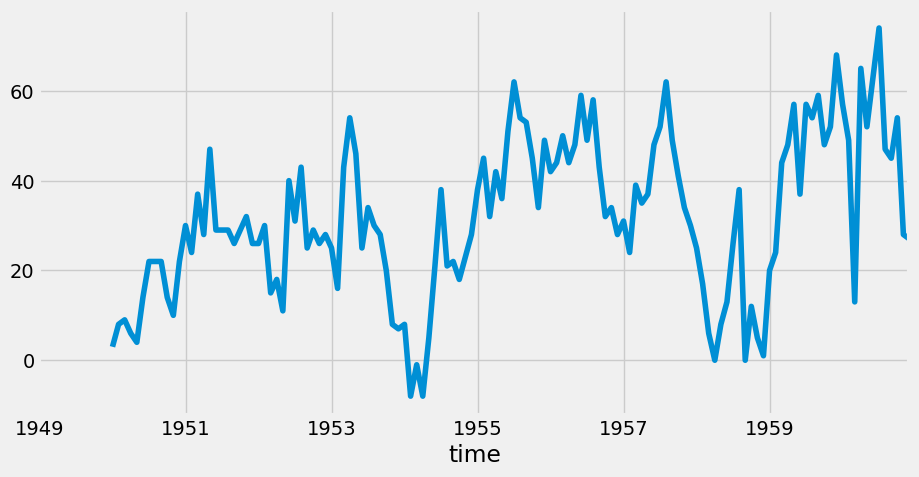

In [ ]:
# стационарность после сезонной разности
df["difference_seasonal"]= diff(df["passengers"], k_diff=0,k_seasonal_diff= 1,seasonal_periods= 12)
df["difference_seasonal"].plot()

In [ ]:
adf_test(df["difference_seasonal"])

ADF тест                       -3.383021
p-value                         0.011551
# lags used                     1.000000
# наблюдения                  130.000000
критическое значение (1%)      -3.481682
критическое значение (5%)      -2.884042
критическое значение (10%)     -2.578770
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


### Подготовка данных

In [24]:
len(df)

144

In [25]:
# разделим на тестовый и тренировочный набор данных
TEST_SIZE = 12
train= df.iloc[:len(df)-TEST_SIZE]
test= df.iloc[len(df)-TEST_SIZE:]

In [26]:
print(len(train))
print(len(test))

132
12


In [27]:
# найдем порядок p,d,q
# ARIMA: обучение модели без сезонной составляющей
auto_arima_results= auto_arima(train["passengers"],
           start_p=0,
           start_q=0,
           max_p=5,
           max_q=5,
           m=1,
           d=None,
           seasonal=False,
           start_P=0,
           D=0,
           trace=True,
           error_action='ignore',
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1277.589, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1268.313, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1264.738, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1276.259, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1258.440, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1262.608, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1263.896, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1218.683, Time=0.77 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.17 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -603.341
Date:                Fri, 28 Mar 2025   AIC                           1218.683
Time:                        20:16:42   BIC                           1235.934
Sample:                    01-01-1949   HQIC                          1225.692
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7157      0.212      3.379      0.001       0.301       1.131
ar.L1          1.6431      0.028     57.904      0.000       1.587       1.699
ar.L2         -0.9129      0.027    -33.338      0.000      -0.967      -0.859
ma.L1         -1.8478      0.036    -51.463      0.000      -1.918      -1.777
ma.L2          0.9466      0.038     24.988      0.000       0.872       1.021
sigma2       564.8460     67.205      8.405      0.000     433.126     696.566
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.36   Prob(JB):                         0.39
Heteroskedasticity (H):               6.40   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

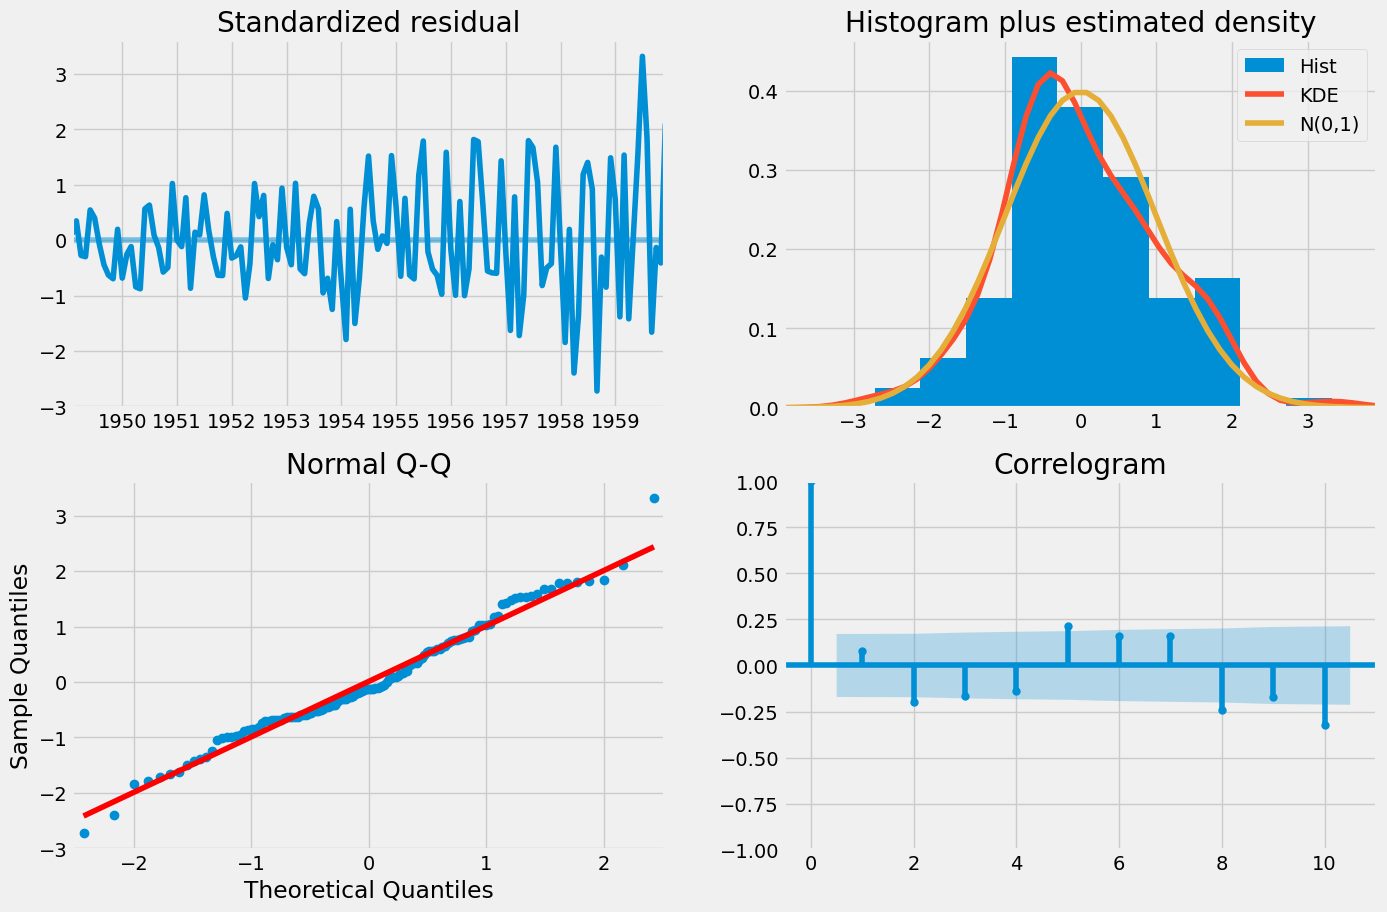

In [ ]:
# интерпретация ARIMA модели в виде графиков
auto_arima_results.plot_diagnostics(figsize=(15,10))
plt.show()

## Моделирование и прогноз


###ARIMA

In [28]:
# обучим модель ARIMA используя p,d,q из полученного результата по auto_arima
arima_model= ARIMA(train["passengers"], order= (2,1,2), freq=train.index.inferred_freq)
arima_model_fit= arima_model.fit()

c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [29]:
normaltest(arima_model_fit.resid)
# если p-value не менее 0.05 , это означает, что остатки нормально распределены

NormaltestResult(statistic=14.011300284626461, pvalue=0.0009067442308106262)

In [30]:
# сделаем прогноз на test наборе данных
start= len(train)
end= len(train) + len(test) -1

pred= arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

<Axes: title={'center': 'Актуальность и Прогноз для Test набора данных'}, xlabel='time'>

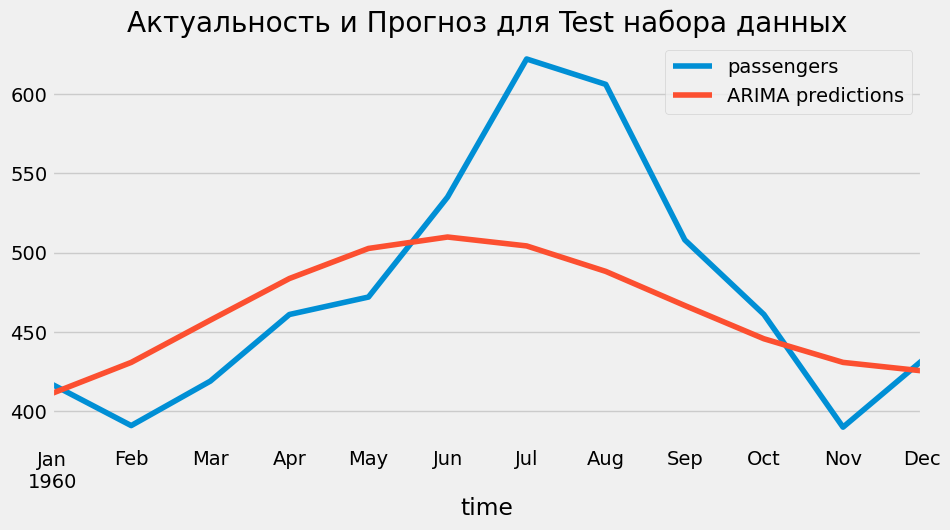

In [31]:
title= "Актуальность и Прогноз для Test набора данных"
test["passengers"].plot(title= title, legend=True);
pred.plot(legend=True)

In [32]:
# Построение модели I
p = 2
d = 1
q = 2
model_d = ARIMA(train['passengers'], order=(0,d,0))
results_d_fit = model_d.fit()

c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: title={'center': 'Актуальность и Прогноз для Test набора данных интеграционная составляющая ARIMA'}, xlabel='time'>

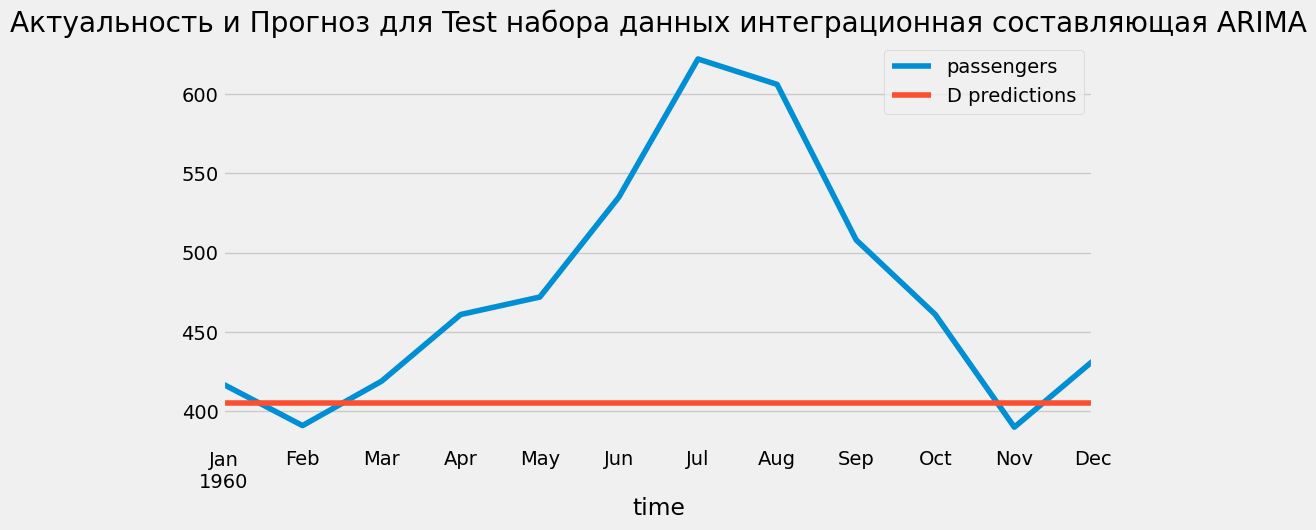

In [33]:
pred_results_d = results_d_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("D predictions")
title= "Актуальность и Прогноз для Test набора данных интеграционная составляющая ARIMA"
test["passengers"].plot(title= title, legend=True);
pred_results_d.plot(legend=True)

In [35]:
# Построение модели AR
p = 2
d = 1
q = 2
model_ar = ARIMA(train['passengers'], order=(p,0,0))
results_ar_fit = model_ar.fit()

c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: title={'center': 'Актуальность и Прогноз для Test набора данных модели AR'}, xlabel='time'>

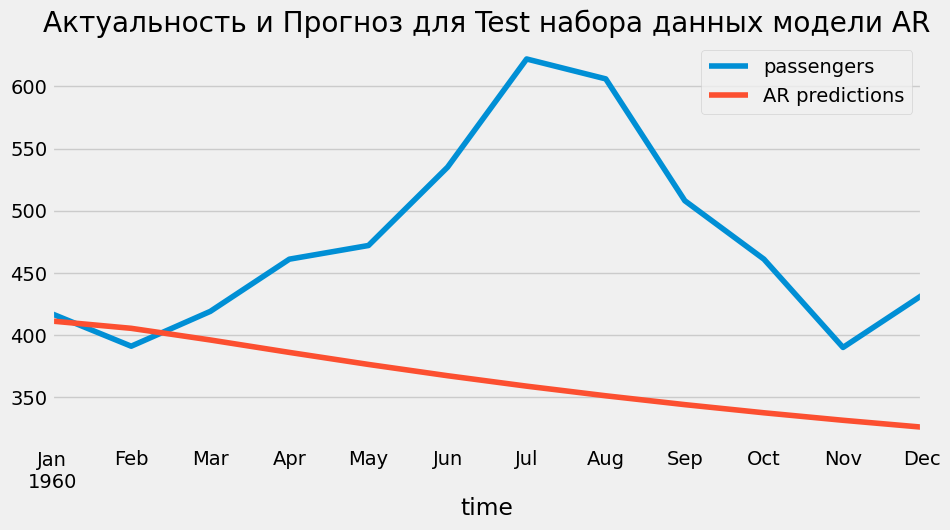

In [36]:
pred_results_ar = results_ar_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("AR predictions")
title= "Актуальность и Прогноз для Test набора данных модели AR"
test["passengers"].plot(title= title, legend=True);
pred_results_ar.plot(legend=True)

In [37]:
# Построение модели MA
p = 2
d = 1
q = 2
model_ma = ARIMA(df['passengers'], order=(0,0,q))
results_ma_fit = model_ma.fit()

c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<Axes: title={'center': 'Актуальность и Прогноз для Test набора данных модели AR'}, xlabel='time'>

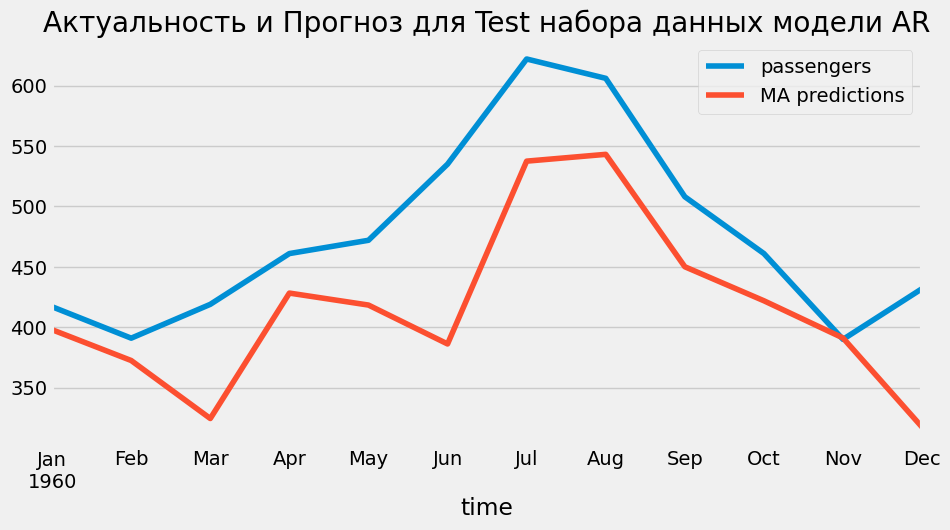

In [38]:
pred_results_ma = results_ma_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("MA predictions")
title= "Актуальность и Прогноз для Test набора данных модели AR"
test["passengers"].plot(title= title, legend=True);
pred_results_ma.plot(legend=True)

### Оценка модели

Подробнее https://education.yandex.ru/handbook/ml/article/modeli-vida-arima

In [39]:
# оценим модель по штрафным баллам
mse= mean_squared_error(test["passengers"],pred)
rmse_arima= rmse(test["passengers"], pred)

print(f"RMSE= {rmse_arima} \n")
print(f"MSE= {mse}")

RMSE= 55.222838919110835 

MSE= 3049.5619382860623


### Получение данных после прогноза

Использование метода forecast() с параметром full_results=True

In [47]:
forecast_steps = 30  # Количество шагов для прогнозирования
forecast_results =  results_ma_fit.forecast(steps=forecast_steps)
 # Этот метод вернет объект с датами и значениями прогноза
forecast_results

1961-01-01    436.688268
1961-02-01    393.495398
1961-03-01    280.409482
1961-04-01    280.409482
1961-05-01    280.409482
1961-06-01    280.409482
1961-07-01    280.409482
1961-08-01    280.409482
1961-09-01    280.409482
1961-10-01    280.409482
1961-11-01    280.409482
1961-12-01    280.409482
1962-01-01    280.409482
1962-02-01    280.409482
1962-03-01    280.409482
1962-04-01    280.409482
1962-05-01    280.409482
1962-06-01    280.409482
1962-07-01    280.409482
1962-08-01    280.409482
1962-09-01    280.409482
1962-10-01    280.409482
1962-11-01    280.409482
1962-12-01    280.409482
1963-01-01    280.409482
1963-02-01    280.409482
1963-03-01    280.409482
1963-04-01    280.409482
1963-05-01    280.409482
1963-06-01    280.409482
Freq: MS, Name: predicted_mean, dtype: float64

In [49]:
np.mean(forecast_results)

289.38830529838214

### SARIMA

In [ ]:
# найдем порядок p,d,q, сезонность P, D, Q
# ARIMA: обучение модели с сезонной составляющей
smodel = auto_arima(train["passengers"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=1.69 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=1.68 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=1.74 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.14 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=2.39 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.64 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=4.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.82 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=3.06 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=2.98 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=1.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=1.54 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Fri, 06 Sep 2024   AIC                            905.686
Time:                                    19:15:26   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# обучим модель
sarima_model= SARIMAX(train["passengers"], order= (3,0,0), seasonal_order= (0,1,0,12), freq=train.index.inferred_freq)
sarima_model_fit= sarima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# сделаем прогнозы на Test данных
start= len(train)
end= len(train) + len(test) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")


<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='time'>

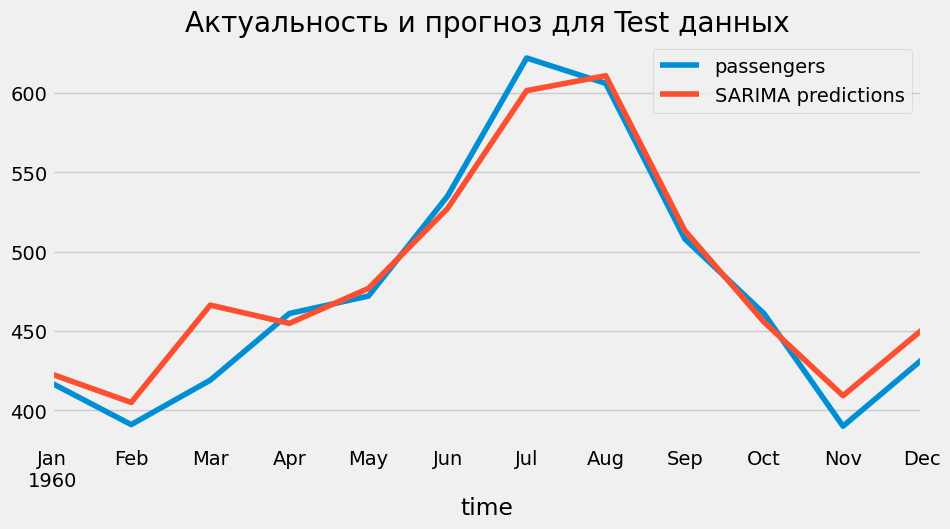

In [ ]:
# построим прогноз
title= "Актуальность и прогноз для Test данных"
test["passengers"].plot(title= title, legend=True)
pred.plot(legend=True)

### Оценка модели

In [ ]:
# оценим модель
mse= mean_squared_error(test["passengers"],pred)
rmse_sarima= rmse(test["passengers"], pred)

print(f"RMSE= {rmse_sarima} \n")
print(f"MSE= {mse}")

RMSE= 17.81560143047715 

MSE= 317.39565432961956


In [ ]:
# подсчитаем сезонный индекс
result_mul = seasonal_decompose(train['passengers'],   # 3 years
                                model='multiplicative',
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

In [ ]:
result_mul

In [ ]:
# соединим его с Train данными
train['month'] = train.index.month
train2 = pd.merge(train, seasonal_index, how='left', on='month')

train2.index = train.index  # переопределим первичный индекс

<ipython-input-54-259347552397>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month


In [ ]:
train2.head(14)

,passengers,12-month-SMA,12-month-Std,difference_1,difference_2,difference_seasonal,month,seasonal
time,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN,NaN,1,0.909983
1949-02-01,118,NaN,NaN,6.0,NaN,NaN,2,0.893216
1949-03-01,132,NaN,NaN,14.0,8.0,NaN,3,1.021380
1949-04-01,129,NaN,NaN,-3.0,-17.0,NaN,4,0.979458
1949-05-01,121,NaN,NaN,-8.0,-5.0,NaN,5,0.976657
1949-06-01,135,NaN,NaN,14.0,22.0,NaN,6,1.105417
1949-07-01,148,NaN,NaN,13.0,-1.0,NaN,7,1.223636
1949-08-01,148,NaN,NaN,0.0,-13.0,NaN,8,1.217181
1949-09-01,136,NaN,NaN,-12.0,-12.0,NaN,9,1.057779


In [ ]:
# соединим его с Test данными
test['month'] = test.index.month
test2 = pd.merge(test, seasonal_index, how='left', on='month')
test2.index = test.index  # переопределим первичный индекс

<ipython-input-56-c35e0427758f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test.index.month


In [ ]:
test2

,passengers,12-month-SMA,12-month-Std,difference_1,difference_2,difference_seasonal,month,seasonal
time,,,,,,,,
1960-01-01,417,433.083333,66.624399,12.0,-31.0,57.0,1,0.909983
1960-02-01,391,437.166667,61.866180,-26.0,-38.0,49.0,2,0.893216
1960-03-01,419,438.250000,61.382741,28.0,54.0,13.0,3,1.021380
1960-04-01,461,443.666667,60.171472,42.0,14.0,65.0,4,0.979458
1960-05-01,472,448.000000,60.184565,11.0,-31.0,52.0,5,0.976657
1960-06-01,535,453.250000,65.021849,63.0,52.0,63.0,6,1.105417
1960-07-01,622,459.416667,77.194510,87.0,24.0,74.0,7,1.223636
1960-08-01,606,463.333333,83.630500,-16.0,-103.0,47.0,8,1.217181
1960-09-01,508,467.083333,84.617276,-98.0,-82.0,45.0,9,1.057779


###SARIMAX

In [ ]:
# SARIMAX модель
sxmodel = auto_arima(train2["passengers"],
                     exogenous=train2[['seasonal']],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=1.51 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=6.15 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.09 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=1.82 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.79 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.34 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.64 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.19 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.46 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Fri, 06 Sep 2024   AIC                            905.686
Time:                                    19:16:10   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# обучение модели
sarimax_model= SARIMAX(train2["passengers"], order= (1,1,0), seasonal_order= (1,0,0,12),exog=train2[['seasonal']], freq=train.index.inferred_freq)
sarimax_model_fit= sarimax_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# прогнозы на Test
start= len(train)
end= len(train) + len(test) -1
pred= sarimax_model_fit.predict(start=start, end=end, dynamic=False, typ="levels",exog=test2[['seasonal']]).rename("SARIMAX with Exog")

<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='time'>

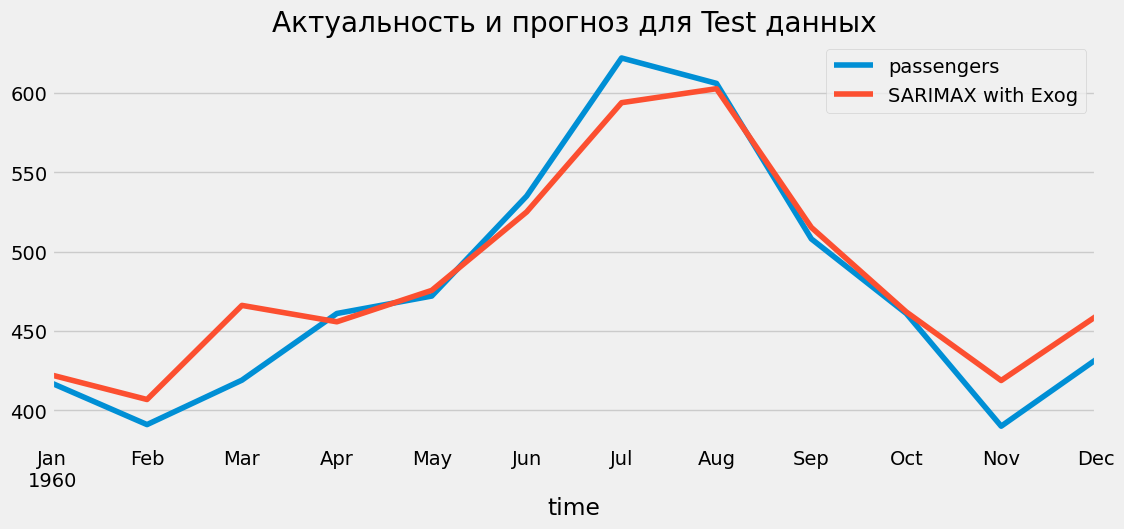

In [ ]:
title= "Актуальность и прогноз для Test данных"
test["passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

### Оценка модели

Подробнее об оценке https://education.yandex.ru/handbook/ml/article/modeli-vida-arima

In [ ]:
# оценка модели
mse= mean_squared_error(test["passengers"],pred)
rmse_sarimax= rmse(test["passengers"], pred)

print(f"Root Mean Square is {rmse_sarimax} \n")
print(f"Mean Square Error is {mse}")

Root Mean Square is 20.540661836746057 

Mean Square Error is 421.91878869155585


In [ ]:
# перетренируем модель на всем объеме данных для прогноза (по AIC 905.69)
model= SARIMAX(df["passengers"], order= (3,0,0), seasonal_order= (0,1,0,12), freq=train.index.inferred_freq)
results= model.fit()

start= len(df)
end= len(df) + len(test) -1

pred= results.predict(start=start, end=end, dynamic=False, typ="levels").rename("Future Forecasts")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='time'>

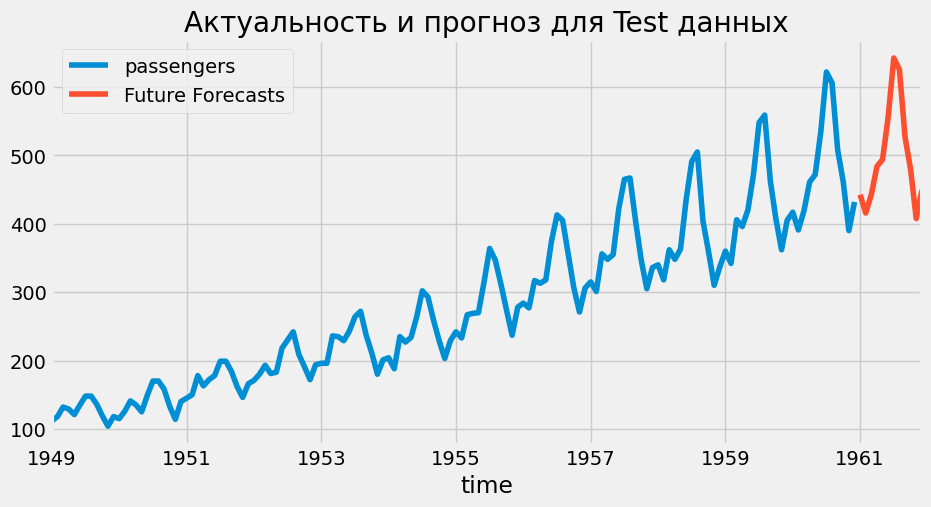

In [ ]:
# прогноз
df["passengers"].plot(title= title, legend=True)
pred.plot(legend=True)

### Оценка модели

In [ ]:
# оценка модели
mse= mean_squared_error(test["passengers"],pred)
rmse_sarimax= rmse(test["passengers"], pred)

print(f"Root Mean Square is {rmse_sarimax} \n")
print(f"Mean Square Error is {mse}")

Root Mean Square is 21.233236783186396 

Mean Square Error is 450.85034429085977


In [ ]:
forecast_steps = 30  # Количество шагов для прогнозирования
forecast = results.get_forecast(steps=forecast_steps)

forecast.summary_frame()

passengers,mean,mean_se,mean_ci_lower,mean_ci_upper
1961-01-01,442.572261,11.584835,419.866402,465.278121
1961-02-01,415.759407,13.961375,388.395615,443.123199
1961-03-01,442.804702,16.444961,410.573171,475.036234
1961-04-01,483.944999,18.272958,448.130660,519.759338
1961-05-01,494.096429,19.872873,455.146313,533.046544
1961-06-01,556.286061,21.233120,514.669910,597.902211
1961-07-01,642.503076,22.426756,598.547442,686.458709
1961-08-01,625.749692,23.478404,579.732866,671.766518
1961-09-01,527.023718,24.414207,479.172752,574.874683
1961-10-01,479.324523,25.251318,429.832850,528.816197
